## 1. Getting started

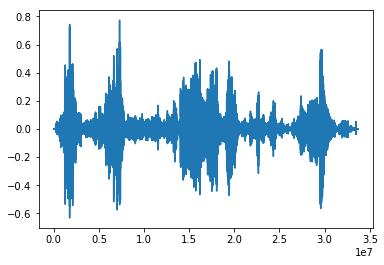

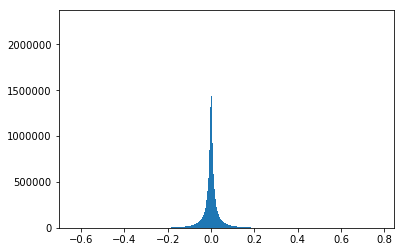

In [2]:
%matplotlib inline
import numpy as np
import scipy.io
import matplotlib.pyplot as plt

#load dataset
mat_contents = scipy.io.loadmat("/afs/inf.ed.ac.uk/group/teaching/mlprdata/audio/amp_data.mat")
amp_data = mat_contents['amp_data']
#histogram
plt.plot(amp_data)
plt.show()
plt.hist(amp_data, bins=1000)
plt.show()
#reshape dataset
row_num = amp_data.shape[0]
remainder = row_num % 21;
amp_data = amp_data[0:(row_num-remainder)];
amp_data = amp_data.reshape((-1,21))

In [4]:
#shuffle rows of the matrix
np.random.seed(0)
rand_perm = np.random.permutation(amp_data.shape[0])
shuf_data = amp_data[rand_perm,:]
row_num = shuf_data.shape[0]
train = shuf_data[:round(row_num*0.7),:]
val = shuf_data[round(row_num*0.7):round(row_num*0.85),:]
test = shuf_data[round(row_num*0.85):,:]

X_shuf_train = train[:,:20];
y_shuf_train = train[:,20];
X_shuf_val = val[:,:20];
y_shuf_val = val[:,20];
X_shuf_test = test[:,:20];
y_shuf_test = test[:,20];

print(X_shuf_train.shape, y_shuf_train.shape)
print(X_shuf_val.shape, y_shuf_val.shape)
print(X_shuf_test.shape, y_shuf_test.shape)

(1123776, 20) (1123776,)
(240809, 20) (240809,)
(240809, 20) (240809,)


## 2. Curve fitting on a snippet of audio:
### a) Plot 20 training points, a test point, a straight line fit, and a quartic fit. 

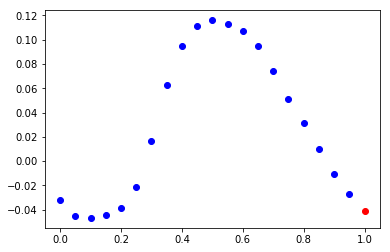

In [24]:
#plot dataset
X = X_shuf_train[0,:]
tt = np.arange(0,1,0.05)[:,None]
# print(x.shape)
# print(t.shape)
# print(amp_data.shape)
# print(amp_data)
plt.plot(t,x,'bo')
plt.plot(1,y_shuf_train[0],'ro')
plt.show()

Weights are [-0.00631757  0.07824478]


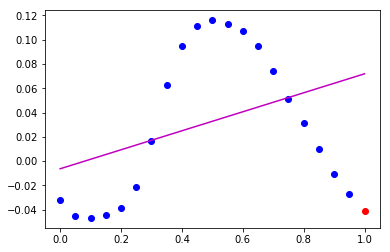

In [68]:
#linear fit by least squares
def phi_linear(X):
    return np.concatenate([np.ones((X.shape[0],1)), X], axis=1)
ww = np.linalg.lstsq(phi_linear(tt), X, rcond=-1)[0]
print("Weights are", ww)
t_grid = np.arange(0, 1.05, 0.05)[:,None]
f_grid = np.dot(phi_linear(t_grid), ww)
plt.plot(t,x,'bo')
plt.plot(1,y_shuf_train[0],'ro')
plt.plot(t_grid, f_grid, 'm-')
plt.show()

Weights are [-0.02265502 -0.88557282  5.9969478  -9.63376427  4.52822088]


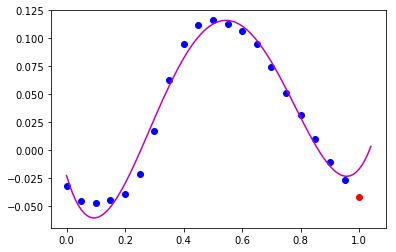

In [71]:
#quartic fit
def phi_quartic(X):
    return np.concatenate([np.ones((X.shape[0],1)),\
                           X, X**2, X**3, X**4], axis=1)
ww = np.linalg.lstsq(phi_quartic(tt), X, rcond=-1)[0]
print("Weights are", ww)
t_grid = np.arange(0, 1.05, 0.01)[:,None]
f_grid = np.dot(phi_quartic(t_grid), ww)
plt.plot(t,x,'bo')
plt.plot(1,y_shuf_train[0],'ro')
plt.plot(t_grid, f_grid, 'm-')
plt.show()

### b) Explain why the linear fit might be better if we use only the most recent two points. Also explain why the quartic fit might be better with a longer context. 

Weights are [ 0.28381348 -0.32714844]


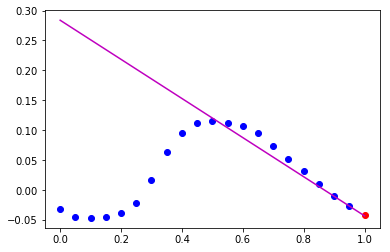

In [80]:
X = X_shuf_train[0,18:]
tt = np.arange(0.9,1,0.05)[:,None]
ww = np.linalg.lstsq(phi_linear(tt), X, rcond=-1)[0]
print("Weights are", ww)
t_grid = np.arange(0, 1.05, 0.05)[:,None]
f_grid = np.dot(phi_linear(t_grid), ww)
plt.plot(t,x,'bo')
plt.plot(1,y_shuf_train[0],'ro')
plt.plot(t_grid, f_grid, 'm-')
plt.show()

TODO: Explain why the linear fit might be better if we use only the most recent two points.

TODO: Also explain why the quartic fit might be better with a longer context.

### c) What order of polynomial and context length do you guess might be best for prediction?

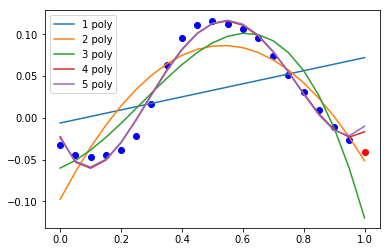

In [114]:
def phi_1(X):
    return np.concatenate([np.ones((X.shape[0],1)), X], axis=1)
def phi_2(X):
    return np.concatenate([np.ones((X.shape[0],1)),X, X**2], axis=1)
def phi_3(X):
    return np.concatenate([np.ones((X.shape[0],1)),X, X**2, X**3], axis=1)
def phi_4(X):
    return np.concatenate([np.ones((X.shape[0],1)),X, X**2, X**3, X**4], axis=1)
def phi_5(X):
    return np.concatenate([np.ones((X.shape[0],1)),X, X**2, X**3, X**4, X**5], axis=1)
polyfuns = [phi_1, phi_2, phi_3, phi_4, phi_5]

X = X_shuf_train[0,:]
tt = np.arange(0,1,0.05)[:,None]
plt.plot(t,x,'bo')
plt.plot(1,y_shuf_train[0],'ro')

t_grid = np.arange(0, 1.05, 0.05)[:,None]
for funIdx in range(len(polyfuns)):
    ww = np.linalg.lstsq(polyfuns[funIdx](tt), X, rcond=-1)[0]
    # print(funIdx+1, "order poly, weights are", ww)
    f_grid = np.dot(polyfuns[funIdx](t_grid), ww)
    plt.plot(t_grid, f_grid, label=str(funIdx+1)+" poly")
plt.legend(loc='upper left')
plt.show()


TODO: What order of polynomial and context length do you guess might be best for prediction?

## 3. Choosing a polynomial predictor based on performance

a) TODO: expression of v

### b) 
#### i) Construct a C×K design matrix

In [188]:
def Phi(C, K):
    X = np.linspace(1-C*0.05,1,num=C,endpoint=False)[:,None]
    phi = np.ones((X.shape[0],1))
    for k in range(K-1):
        phi = np.concatenate([phi, X**(k+1)], axis=1)
    return phi

[[1.         0.75       0.5625     0.421875   0.31640625 0.23730469
  0.17797852]
 [1.         0.8        0.64       0.512      0.4096     0.32768
  0.262144  ]
 [1.         0.85       0.7225     0.614125   0.52200625 0.44370531
  0.37714952]
 [1.         0.9        0.81       0.729      0.6561     0.59049
  0.531441  ]
 [1.         0.95       0.9025     0.857375   0.81450625 0.77378094
  0.73509189]]


In [ ]:
order = 4

def ls(x,y):
    y=np.dot(x.T,y)
    y=np.reshape(y,(-1,1))
    xx=np.dot(x.T,x)
    xx=np.mat(xx)
    x=xx.I
    c=x*y
    print(c)
    return c